<a href="https://colab.research.google.com/github/vlad-danaila/ml-cancer-detection/blob/master/Cancer_Detection_Ensable_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install sklearn matplotlib GPUtil

In [ ]:
!pip3 install "pillow<7"

In [ ]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html

**Download Data**

Mount my google drive, where the dataset is stored.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print(e)

Unzip the dataset into the folder "dataset".

In [ ]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

**Constants**

In [29]:
# TRAIN_PATH = '/content/dataset/data/train/'
# TEST_PATH = '/content/dataset/data/test/'
TRAIN_PATH = 'dataset/data/train/'
TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

# prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
prefix = 'Mobilenetv2 Tuning/'
CHACKPOINT_CROSS_ENTROPY_MODEL = prefix + 'checkpint resnet18.tar'

**Imports**

In [2]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import statistics
import math

**Deterministic Measurements**

This statements help making the experiments reproductible by fixing the random seeds.

In [3]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Memory Stats**

In [4]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB
GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB


**Loading Data**

The dataset is structured in multiple small folders, ecah containing 7 images. The generator iterates through the folders and returns the category and 7 paths: one for each image in the folder.

In [5]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which loads 3 kinds of images: natural images, images taken through a green lens and images where the doctor aplied iodine solution (which gives a dark red colour). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [6]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [7]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [8]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [9]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [10]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [11]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [12]:
# x, y = next(iter(loader_train_simple_img))
# for i in range(7):
#   plot_predictions(x[i], y, y)

**Model**

In [13]:
def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc.out_features = 4
  model = model.cuda()
  return model

In [14]:
model_simple = t.nn.DataParallel(get_resnet_18())

**Train & Evaluate**

Timer utility function. This is used to measure the execution speend.

In [15]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and e valuates it at the same time. It outputs the metrics recorder during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is imporved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [16]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': [],

      'mean_class_acc_train': [],
      'mean_class_acc_test': []  
  }

  best_mean_acc = 0
  
  loss_weights = t.tensor([1/4] * 4, device='cuda:0')
    
  try:  
    for epoch in range(epochs):
      timer_start()
      loss_fn = t.nn.CrossEntropyLoss(weight = loss_weights)
      # loss_fn = t.nn.CrossEntropyLoss()
      # loss_fn = FocalLoss(gamma = 2)
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      conf_matrix = np.zeros((4, 4))
      for x, y in loader_train:
        y_pred = model.forward(x)
        y_pred = y_pred.narrow(1, 0, 4)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
        conf_matrix += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      mean_class_acc = statistics.harmonic_mean(class_acc)
      errors = [1 - conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      errors_strong = [math.exp(100 * e) for e in errors]
      loss_weights = t.tensor([e / sum(errors_strong) for e in errors_strong], device = 'cuda:0')
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
      metrics['mean_class_acc_train'].append(mean_class_acc) 

      # Evaluate
      model.eval()
      with t.no_grad():
        conf_matrix_test = np.zeros((4, 4))
        for x, y in loader_test:
          y_pred = model.forward(x)
          y_pred = y_pred.narrow(1, 0, 4)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
          conf_matrix_test += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
        class_acc_test = [conf_matrix_test[i][i] / sum(conf_matrix_test[i]) for i in range(len(conf_matrix_test))]
        mean_class_acc_test = statistics.harmonic_mean(class_acc_test)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
        metrics['mean_class_acc_test'].append(mean_class_acc_test) 
      
      if metrics['mean_class_acc_test'][-1] > best_mean_acc:
        best_mean_acc = metrics['mean_class_acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} mean class acc {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['mean_class_acc_test'][-1], metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [17]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

In [18]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [19]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['mean_class_acc_test']).argmax()
    print('Best mean class accuracy :', metrics['mean_class_acc_test'][index_max])
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['mean_class_acc_train'], metrics['mean_class_acc_test'], 'Mean Class Accuracy (lr = {})'.format(learn_rate), 'Mean Class Accuracy')
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

Perform actual training

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.6/statistics.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 mean class acc 0.059561295831776696 acc 0.3291666666666667 prec 0.30352710233029384 rec 0.1579861111111111 f 0.18268976381263352 minutes 0.3932771682739258
Epoch 2 mean class acc 0.36578171091445427 acc 0.3916666666666667 prec 0.3042099981755155 rec 0.20902777777777778 f 0.2419997441340248 minutes 0.1974022626876831
Epoch 3 mean class acc 0.3265625 acc 0.47500000000000003 prec 0.3160819814137892 rec 0.2923611111111111 f 0.2829538602702461 minutes 0.18656533161799113
Epoch 4 mean class acc 0.31310519262349235 acc 0.4541666666666667 prec 0.3027810694034098 rec 0.275 f 0.2664595064119662 minutes 0.18716487487157185
Epoch 5 mean class acc 0.3611415102281337 acc 0.4375 prec 0.3113629880831643 rec 0.2560763888888889 f 0.2716181315857542 minutes 0.19147032499313354
Epoch 6 mean class acc 0.40306244041944705 acc 0.4416666666666667 prec 0.34551221804511273 rec 0.26371527777777776 f 0.2908371810673265 minutes 0.18994338909784952
Epoch 7 mean class acc 0.3886104131133881 acc 0.47083333333

Epoch 53 mean class acc 0.44467374810318666 acc 0.4791666666666667 prec 0.44550758078998265 rec 0.2714120370370371 f 0.3324400923339058 minutes 0.1915475010871887
Epoch 54 mean class acc 0.40292566763054943 acc 0.4833333333333334 prec 0.38397814981398193 rec 0.23315972222222225 f 0.2794918260270478 minutes 0.19046912988026937
Epoch 55 mean class acc 0.5334257014201593 acc 0.5916666666666667 prec 0.39541969330104926 rec 0.2994791666666667 f 0.33694057920064113 minutes 0.19010429779688517
Epoch 56 mean class acc 0.5216853051623819 acc 0.6041666666666666 prec 0.39233174081035926 rec 0.32517361111111115 f 0.34672269030215347 minutes 0.18381082614262897
Epoch 57 mean class acc 0.5105699221692193 acc 0.5291666666666667 prec 0.378671223100571 rec 0.27239583333333334 f 0.3139544361326014 minutes 0.23138746817906697
Epoch 58 mean class acc 0.4768211920529801 acc 0.4875 prec 0.4006637377173091 rec 0.2578125 f 0.3109836703875176 minutes 0.21459693908691407
Epoch 59 mean class acc 0.45610282706969

Epoch 105 mean class acc 0.5257982789185465 acc 0.5541666666666667 prec 0.392343716332687 rec 0.2737847222222222 f 0.3212175976610925 minutes 0.19209155639012654
Epoch 106 mean class acc 0.5194707844533564 acc 0.5458333333333334 prec 0.39291701212257485 rec 0.27013888888888893 f 0.318057544390265 minutes 0.19127002954483033
Epoch 107 mean class acc 0.46201358863495984 acc 0.5208333333333333 prec 0.4055395004217468 rec 0.2595486111111111 f 0.30977349739009846 minutes 0.19034045139948527
Epoch 108 mean class acc 0.42156673735621103 acc 0.47500000000000003 prec 0.4293040293040293 rec 0.24756944444444443 f 0.30501664811692697 minutes 0.19255896806716918
Epoch 109 mean class acc 0.47056951956729237 acc 0.525 prec 0.40458650316187084 rec 0.2647569444444444 f 0.3143165004525947 minutes 0.19131852785746256
Epoch 110 mean class acc 0.48708504717301293 acc 0.5375 prec 0.406084950815343 rec 0.26979166666666665 f 0.3191843644509086 minutes 0.18960497776667276
Epoch 111 mean class acc 0.52537313432

Epoch 157 mean class acc 0.4602369852369852 acc 0.5 prec 0.3819475626324031 rec 0.23906249999999998 f 0.28729863072448003 minutes 0.21430671612421673
Epoch 158 mean class acc 0.4725722406442444 acc 0.5249999999999999 prec 0.3956806718562125 rec 0.2690972222222222 f 0.3168938412677646 minutes 0.19013821681340534
Epoch 159 mean class acc 0.4825744910169477 acc 0.5291666666666667 prec 0.39650304027726513 rec 0.2717013888888889 f 0.3194244439042994 minutes 0.18759398063023885
Epoch 160 mean class acc 0.47276816377638786 acc 0.5166666666666666 prec 0.37094155844155846 rec 0.2508680555555556 f 0.2959160061042254 minutes 0.18750911553700764
Epoch 161 mean class acc 0.45620187542883284 acc 0.5125 prec 0.38784277065527073 rec 0.24913194444444442 f 0.29710848732587863 minutes 0.18749339977900187
Epoch 162 mean class acc 0.46809662937361934 acc 0.525 prec 0.37912845560871883 rec 0.2508680555555556 f 0.2970723937718368 minutes 0.18804763555526732
Epoch 163 mean class acc 0.4901557949680931 acc 0.5

Epoch 208 mean class acc 0.4961890243902439 acc 0.5333333333333333 prec 0.3912266841954342 rec 0.25746527777777783 f 0.30498324167215524 minutes 0.18906118869781494
Epoch 209 mean class acc 0.4854468085106383 acc 0.5291666666666667 prec 0.3946677623940555 rec 0.2548611111111111 f 0.3029204646420574 minutes 0.19054003556569418
Epoch 210 mean class acc 0.46884410470233956 acc 0.5083333333333334 prec 0.3985508697451507 rec 0.24861111111111112 f 0.29828195431249205 minutes 0.18724152247111003
Epoch 211 mean class acc 0.47050147492625366 acc 0.5083333333333334 prec 0.3965234644582471 rec 0.24756944444444448 f 0.29761234970646 minutes 0.18885955810546876
Epoch 212 mean class acc 0.47973531844499584 acc 0.5333333333333334 prec 0.40399494263285024 rec 0.25798611111111114 f 0.30473539913730474 minutes 0.1793972055117289
Epoch 213 mean class acc 0.4794520547945206 acc 0.5333333333333334 prec 0.4183201058201058 rec 0.26493055555555556 f 0.31471506859365833 minutes 0.2338727633158366
Epoch 214 mea

Epoch 260 mean class acc 0.4546292880855773 acc 0.525 prec 0.3994101112667289 rec 0.25538194444444445 f 0.3014649743686321 minutes 0.18642096916834514
Epoch 261 mean class acc 0.46219201359388273 acc 0.5291666666666667 prec 0.40719283447225907 rec 0.2637152777777778 f 0.3118096017023549 minutes 0.18607638279596964
Epoch 262 mean class acc 0.5046701260192735 acc 0.5541666666666667 prec 0.41423239914619225 rec 0.2826388888888889 f 0.3313941474191329 minutes 0.1879997412363688
Epoch 263 mean class acc 0.4679432381603693 acc 0.5333333333333333 prec 0.41814456991344806 rec 0.2682291666666667 f 0.31818388886695664 minutes 0.1888433853785197
Epoch 264 mean class acc 0.49793040012264295 acc 0.55 prec 0.39661017674027593 rec 0.2732638888888889 f 0.3183849193613095 minutes 0.18859873215357462
Epoch 265 mean class acc 0.4938582677165354 acc 0.5416666666666667 prec 0.3994750999730985 rec 0.2685763888888889 f 0.3156864326559269 minutes 0.19005866448084513
Epoch 266 mean class acc 0.4661941112322791

Epoch 312 mean class acc 0.49775574740942563 acc 0.5333333333333334 prec 0.38868663754247285 rec 0.26250000000000007 f 0.3091845851042062 minutes 0.17761443456013998
Epoch 313 mean class acc 0.4852986691426803 acc 0.5375000000000001 prec 0.4099767839687195 rec 0.27361111111111114 f 0.3219162646838149 minutes 0.17689849932988486
Epoch 314 mean class acc 0.46741573033707867 acc 0.5166666666666666 prec 0.4181543394804519 rec 0.2555555555555556 f 0.30571882779064463 minutes 0.17776566743850708
Epoch 315 mean class acc 0.45289079229122053 acc 0.5083333333333334 prec 0.418520880574452 rec 0.25 f 0.30134620773626103 minutes 0.17735259532928466
Epoch 316 mean class acc 0.44894170070553285 acc 0.5 prec 0.402208928161908 rec 0.24427083333333335 f 0.29442339233762377 minutes 0.17681494156519573
Epoch 317 mean class acc 0.4899808001253869 acc 0.5333333333333334 prec 0.40934037264723744 rec 0.2647569444444445 f 0.3134818065339718 minutes 0.17802830934524536
Epoch 318 mean class acc 0.48963041182682

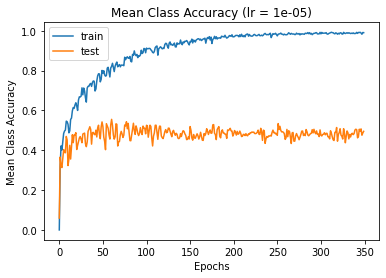

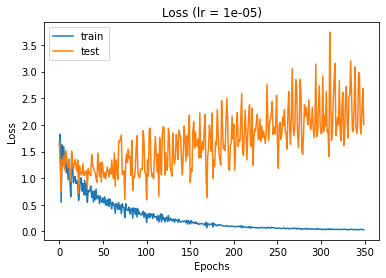

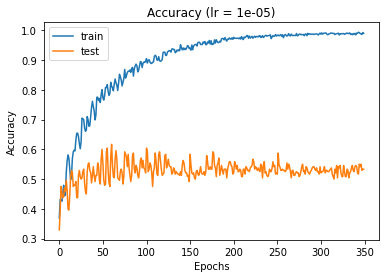

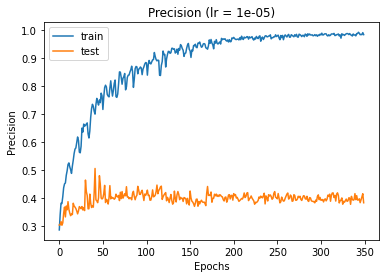

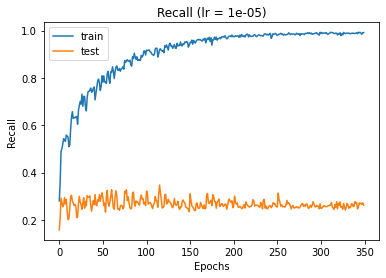

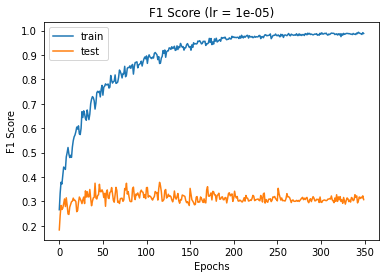

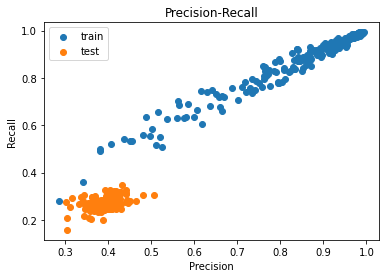

In [20]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'wce_dense_net', [(350, 1e-5)])

In [25]:
checkpoint = t.load('checkpint wce_dense_net.tar')
model_simple.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [26]:
def calculate_class_acc_for_test_set(model):
  model.eval()
  with t.no_grad():
    conf_matrix = np.zeros((4, 4))
    for x, y in loader_test_simple_img:
      y_pred = model.forward(x)
      y_pred = y_pred.narrow(1, 0, 4)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      cm = sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      conf_matrix += cm
    print('Confusion matrix:\n', conf_matrix)
    class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
    print('Class acc:\n', class_acc)
    return class_acc

def plot_class_acc(class_acc):
  plt.bar(list(range(4)), class_acc, align='center', alpha=0.5)
  plt.xticks(list(range(4)), list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.savefig('AccPerClass.pdf', dpi = 300, format = 'pdf')
  plt.show()

def plot_class_acc_comparison(class_acc_1, class_acc_2, title_1, title_2):
  width = .3
  plt.bar(list(range(4)), class_acc_1, width, alpha=0.5, color = 'green', label = title_1)
  plt.bar(np.array(list(range(4))) + width, class_acc_2, width, alpha=0.5, color = 'blue', label = title_2)
  plt.xticks(np.array(list(range(4))) + width/2, list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.savefig('ClassAccCompareDenseNet.pdf', dpi = 300, format = 'pdf')
  plt.show()

Confusion matrix:
 [[45.  1. 11.  3.]
 [16. 34. 10.  0.]
 [14. 20. 21.  5.]
 [ 1.  3.  8. 48.]]
Class acc:
 [0.75, 0.5666666666666667, 0.35, 0.8]


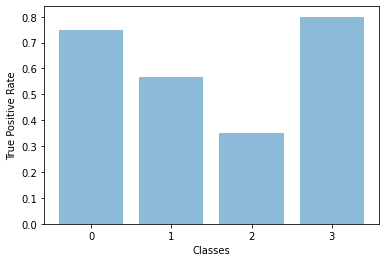

In [27]:
class_acc = calculate_class_acc_for_test_set(model_simple)
plot_class_acc(class_acc)

Confusion matrix:
 [[58.  0.  1.  1.]
 [21. 23. 16.  0.]
 [22.  6. 31.  1.]
 [ 2.  2. 12. 44.]]
Class acc:
 [0.9666666666666667, 0.38333333333333336, 0.5166666666666667, 0.7333333333333333]


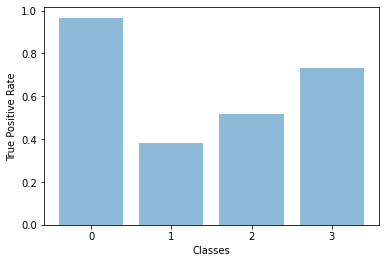

In [30]:
model_without_wl = t.nn.DataParallel(get_resnet_18().cuda())
checkpoint_without_wl = t.load(CHACKPOINT_CROSS_ENTROPY_MODEL)
model_without_wl.load_state_dict(checkpoint_without_wl['model'])
class_acc_no_wl = calculate_class_acc_for_test_set(model_without_wl)
plot_class_acc(class_acc_no_wl)

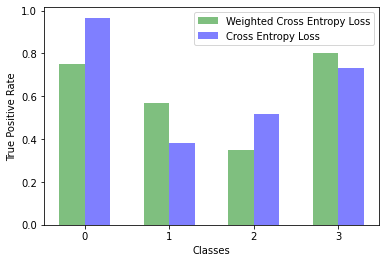

In [31]:
plot_class_acc_comparison(class_acc, class_acc_no_wl, 'Weighted Cross Entropy Loss', 'Cross Entropy Loss')